In [14]:
import xarray 
import numpy as np
import scipy.stats
import pandas as pd
from mpl_toolkits.basemap import Basemap

#cdd is the function to calculate the CDD, the output is a dataframe grouped by lat lon and time_period.

# data_df should be the input daily precipitation dataframe consists of lat, lon, time_period and daily precipitation.
# pr_name is the variable name of precipitation
# period_name is the variable name of period used. like 'year' or 'month'.

def cdd(data_df,pr_name,period_name):
    data_df['Dryness']=np.where(data_df[pr_name]>=1,'non-dry','dry')
    dry_duration = pd.DataFrame(data_df.groupby(['lat','lon',period_name,data_df['Dryness'],(data_df['Dryness']!=data_df['Dryness'].shift()).cumsum()]).size().reset_index(level=4,drop=True).rename('duration'))
    dry_duration_reset_index = dry_duration.reset_index()
    dry_duration_reset_index = dry_duration_reset_index[dry_duration_reset_index.Dryness=='dry']
    CDD_each_grid = pd.DataFrame(dry_duration_reset_index.groupby(['lat','lon',period_name]).duration.max())
    CDD_each_grid = CDD_each_grid.rename(columns={'duration':"CDD"})
    return CDD_each_grid.reset_index()

#score_map is a function to plot a variable on map

# data should be the input dataframe.
# variable_name is varable name of the vairable used like CDD.

def score_map(data,variable_name):

    val_pivot_df = data.pivot(index='lat', columns='lon', values=variable_name)
    lons = val_pivot_df.columns.values
    lats = val_pivot_df.index.values
    fig, ax = plt.subplots(1, figsize=(8,8))
    m = Basemap(projection='merc',
            llcrnrlat=data.dropna().min().lat-2
            , urcrnrlat=data.dropna().max().lat+2
            , llcrnrlon=data.dropna().min().lon-2
            , urcrnrlon=data.dropna().max().lon+2
            , resolution='i', area_thresh=10000
            )
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x, y = np.meshgrid(lons,lats) 
    px,py = m(x,y) 
    data_values = val_pivot_df.values
    masked_data = np.ma.masked_invalid(data_values)
    cmap = plt.cm.viridis
    m.pcolormesh(px, py, masked_data, cmap=cmap,  shading='flat')
    m.colorbar(label=variable_name)


In [22]:
## an example to calculate the CDD values over CONUS and plot it 
# the test data should be daily precipitation 
import matplotlib as mpl
import matplotlib.pyplot as plt
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# The CPC data used here can be downloaded at https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=125&tid=54713&vid=2415
# Here I already use cdo commands to merge the daily precipitaion from 1948 to 1970.

observe_path = "CPC_daily_precipitation_1948-1970.nc"
observe = xarray.open_dataset(observe_path)
observe_df = observe.to_dataframe().reset_index()

# set the period used like year or total historical period. 
observe_df['year'] = pd.DatetimeIndex(observe_df.time).year
observe_df['period'] = 'historical'

# subset the data within a region to save calculation time cost.
test_df = observe_df[(observe_df.lon>=260)&(observe_df.lon<=265)&(observe_df.lat>=40)&(observe_df.lat<=45)]
# If we are interested in CDD in each year, we should change 'period' to 'year'.
CDD_df = cdd(test_df,'precip','period')

# We can see the CDD are grouped by lat, lon and the period we choose
CDD_df

/global/homes/z/zx2217/.conda/envs/mypackage/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,lat,lon,period,CDD
0,40.125,260.125,historical,65
1,40.125,260.375,historical,90
2,40.125,260.625,historical,77
3,40.125,260.875,historical,66
4,40.125,261.125,historical,91
...,...,...,...,...
395,44.875,263.875,historical,66
396,44.875,264.125,historical,70
397,44.875,264.375,historical,70
398,44.875,264.625,historical,60


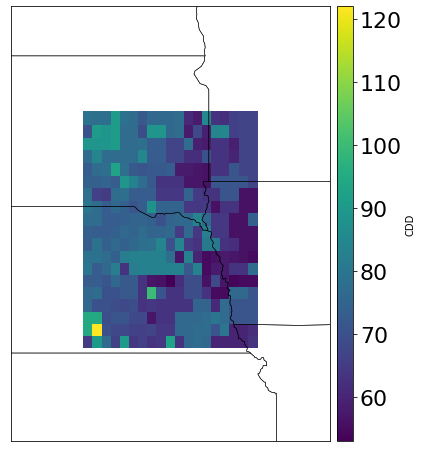

In [23]:
#By score_map, it's easy to plot CDD on map
score_map(CDD_df,'CDD')